In [4]:
import os, time, librosa, librosa.display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras import utils
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop, Adam

import audio_data_loader as audioloader
import audio_data_writer as audiowriter
import references as ref

### Create Dataset

The dataset contains audio data prcessed. 


In [5]:
def get_features(y, sr):
    out = []
    
    out.append(np.mean(librosa.feature.rms(y = y)))
    out.append(np.mean(librosa.feature.spectral_centroid(y = y, sr = sr)))
    out.append(np.mean(librosa.feature.spectral_bandwidth(y = y, sr = sr)))
    out.append(np.mean(librosa.feature.spectral_rolloff(y = y, sr = sr))) 
    out.append(np.mean(librosa.feature.zero_crossing_rate(y)))
    
    for e in librosa.feature.mfcc(y = y, sr = sr):
        out.append(np.min(e))
        out.append(np.mean(e))
        out.append(np.max(e))
        
   
    for e in librosa.feature.chroma_stft(y = y, sr = sr):
        out.append(np.min(e))
        out.append(np.mean(e))
        out.append(np.max(e))

    return out

In [6]:
def get_dataset(source):
    
    x_train = []
    y_train = []
    
    for i, item in tqdm(source.iterrows()):
        
        try:
            # read the audio file
            y, sr = audioloader.read_audio(item[0])
            
            # append x_train item
            x_train.append(get_features(y, sr))
            y_train.append(item[8])
            
        except:
            
            print(f'Invalid object {item[0]}')
            
    
    x_train, x_val, y_train, y_val = train_test_split(np.array(x_train), 
                                                      np.array(y_train), 
                                                      test_size = 0.1, 
                                                      random_state = 42, 
                                                      shuffle = True)        
        
    return x_train, x_val, y_train, y_val 

### Neural network model builder

In [29]:
def get_model(input_size):
    
    model = Sequential()
    model.add(Dense(400, activation = 'relu', input_shape = (input_size,)))
    model.add(Dense(320, activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation = 'relu'))
    model.add(Dense(1, activation = 'sigmoid'))

    model.compile(optimizer = Adam(learning_rate = 0.001),
                  loss = 'binary_crossentropy',
                  metrics = ['accuracy'])
    
    return model

In [27]:
def get_prediction(sample_path, model):
    
    y, sr = audioloader.read_audio(sample_path)
    
    sound_sample = get_features(y, sr)
    sound_sample = np.array(sound_sample)
    
    x = np.expand_dims(sound_sample, axis = 0)
    
    y_pred = model.predict(x)
    index = round(y_pred[0][0])
    
    return 'Gender definded - {}'.format(ref.gender_ref[index])

### Visualizations

In [9]:
def show_accuracy(data):
    
    fig, ax = plt.subplots(figsize = (15, 6))
    
    ax.plot(data.epoch, data.history['accuracy'], label = 'Accuracy')
    ax.plot(data.epoch, data.history['val_accuracy'], label = 'Validation Accuracy')
    
    plt.legend()
    plt.show()

### Training process

In [10]:
source = audioloader.create_source_dataset(ref.root_path)

Data source array is prepared - 0.048868656158447266 c


In [11]:
x_train, x_val, y_train, y_val = get_dataset(source)

1440it [11:15,  2.13it/s]


In [30]:
model = get_model(x_train.shape[1])

In [31]:
history = model.fit(x_train, y_train, batch_size = 50, epochs = 50, validation_split = 0.1)

Epoch 1/50
24/24 [==============================] - 1s 7ms/step - loss: 63.6736 - accuracy: 0.5274 - val_loss: 22.0180 - val_accuracy: 0.5538
Epoch 2/50
24/24 [==============================] - 0s 4ms/step - loss: 12.8001 - accuracy: 0.5858 - val_loss: 2.5253 - val_accuracy: 0.6538
Epoch 3/50
24/24 [==============================] - 0s 3ms/step - loss: 6.1374 - accuracy: 0.6415 - val_loss: 2.1732 - val_accuracy: 0.7462
Epoch 4/50
24/24 [==============================] - 0s 3ms/step - loss: 4.2626 - accuracy: 0.6844 - val_loss: 3.2152 - val_accuracy: 0.6692
Epoch 5/50
24/24 [==============================] - 0s 5ms/step - loss: 2.8377 - accuracy: 0.7401 - val_loss: 1.4527 - val_accuracy: 0.7615
Epoch 6/50
24/24 [==============================] - 0s 7ms/step - loss: 1.9117 - accuracy: 0.7504 - val_loss: 1.6741 - val_accuracy: 0.7615
Epoch 7/50
24/24 [==============================] - 0s 7ms/step - loss: 2.5762 - accuracy: 0.7256 - val_loss: 1.4109 - val_accuracy: 0.7923
Epoch 8/50
24/24 

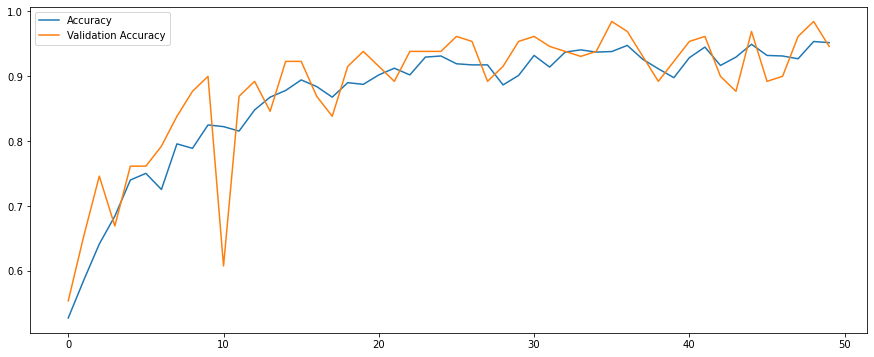

In [32]:
show_accuracy(history)

In [33]:
pred = model.evaluate(x_val, y_val)

5/5 [==============================] - 0s 2ms/step - loss: 0.0721 - accuracy: 0.9722


### Sample Audio recording

In [16]:
sample_filename = audiowriter.write_audio()

* recording
* data recording


In [34]:
result = get_prediction(sample_filename, model)
print(result)

Gender definded - male
